In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("/Users/Yur/Downloads/ovitrap_data_with_province.csv", index_col=[0], usecols = ['date', 'id', 'value', 'adm'])

## Get a summary of the data per school, this makes the datacleaning more easy
    - Get schools with more than 40 observations, to have more reliable measurements
    - Filter schools with a maximum level that is less than 10 (very unlikely, probably misreporting)
    - Filter school with very high means (result of misreporting)
    - Filter schools with more than 75% 100's or 0's
    - Filter schools with only the same observations
    - Remove values that are between (0, 1.5], [98.5, 100)  as it is not plausible that a school has more than 60 ovitraps
    

In [2]:
summary_df = df.groupby(['id']).describe()

In [3]:
summary_df.columns = summary_df.columns.droplevel(0)

In [11]:
n = len(df)
sum_df = summary_df[summary_df['count'] > 40]
print('Lost values more than n values per school: ', n-len(df[df['id'].isin(sum_df.index.tolist())]))
n = len(df[df['id'].isin(sum_df.index.tolist())])

# sum_df = sum_df[~(sum_df['max'] == sum_df['min'])] #removes 0
# print(n-len(df[df['id'].isin(sum_df.index.tolist())]))
# n = len(df[df['id'].isin(sum_df.index.tolist())])

sum_df = sum_df[sum_df['max'] > 10] 
print('Lost values for schools that have a maximum less than 10: ', n-len(df[df['id'].isin(sum_df.index.tolist())]))
n = len(df[df['id'].isin(sum_df.index.tolist())])

sum_df = sum_df[sum_df['mean'] < 90]
print('Lost values for schools with a mean higher than 90: ', n-len(df[df['id'].isin(sum_df.index.tolist())]))
n = len(df[df['id'].isin(sum_df.index.tolist())])

# sum_df = sum_df[~((sum_df['50%']==100))]
# print(n-len(df[df['id'].isin(sum_df.index.tolist())]))
# n = len(df[df['id'].isin(sum_df.index.tolist())])

zeros_df = sum_df[~((sum_df['75%']==0) & (sum_df['max']==100))]
print('75% zeros and a max of 100: ', n-len(df[df['id'].isin(zeros_df.index.tolist())]))
n = len(df[df['id'].isin(zeros_df.index.tolist())])

zeros_df = zeros_df[~(zeros_df['75%']==zeros_df['max'])]
print('75% of values is equal to max: ', n-len(df[df['id'].isin(zeros_df.index.tolist())]))
n = len(df[df['id'].isin(zeros_df.index.tolist())])
test = zeros_df[((zeros_df['mean']<2)&(zeros_df['max']>50))]
zeros_df = zeros_df[~((zeros_df['mean']<2)&(zeros_df['max']>50))]
print('Mean lower than 2 and max higher than 50: ', n-len(df[df['id'].isin(zeros_df.index.tolist())]))
n = len(df[df['id'].isin(zeros_df.index.tolist())])

# get df back from school level to observation level
clean_school_df = (df[df['id'].isin(zeros_df.index.tolist())]) 

clean_df = clean_school_df[~((clean_school_df['value']>0) & (clean_school_df['value']<1.5))] # removes values 0<x<1.5
print('Amount of values that are between 0 < x < 1.5: ', n-len(clean_df))
n=len(clean_df)

clean_df = clean_df[~((clean_df['value']<100) & (clean_df['value']>98.5))] # removes values 98.5<x<100
print('Amount of vaues between 98.5 < x < 100: ', n-len(clean_df))

print('Total amount of values, before last data cleaning part: ', len(clean_df))

Lost values more than n values per school:  94464
Lost values for schools that have a maximum less than 10:  1727
Lost values for schools with a mean higher than 90:  241
75% zeros and a max of 100:  259
75% of values is equal to max:  887
Mean lower than 2 and max higher than 50:  69
Amount of values that are between 0 < x < 1.5:  198
Amount of vaues between 98.5 < x < 100:  6
Total amount of values, before last data cleaning part:  39205


In [10]:
# Export DataFrame to csv file
export_csv = clean_df.to_csv('OviTrapData.csv') 
# S = semifiltered_df[['adm', 'id', 'value']].groupby(['adm', 'id']).describe()

## Create column that reports if a value occurs more than n (n=7) times in a row

In [38]:
# Import filtered dataset
df = pd.read_csv('OviTrapData.csv', parse_dates=['date'], usecols=['date', 'id', 'value', 'adm'])

In [39]:
i=0
sequence = np.zeros(len(df))
while i < len(df)-1:
    j = 1
    value = df.iloc[i, 2]
    value_id = df.iloc[i,1]
    next_value = df.iloc[i+j, 2]
    next_value_id = df.iloc[i+j, 1]
    
    while (next_value == value) and (next_value_id == value_id):
        next_value = df.iloc[i+j, 2]
        next_value_id = df.iloc[i+j, 1]
        j = j + 1
    
    if j > 6:
        sequence[i:(i+j-1)] = (j-1)
        i = i + j - 1
    else:
        i = i + 1
        
df['Recurring value'] = sequence

In [40]:
# adds the number of times a recurrent values occurs given that it occurs more than 5 times in a row
i=0
sequence = np.zeros(len(df))
df = df[['date', 'id', 'value', 'adm']]
while i < len(df)-1:
    j = 1
    value = df.iloc[i, 2]
    value_id = df.iloc[i,1]
    next_value = df.iloc[i+j, 2]
    next_value_id = df.iloc[i+j, 1]
    
    while (next_value == value) and (next_value_id == value_id):
        next_value = df.iloc[i+j, 2]
        next_value_id = df.iloc[i+j, 1]
        j = j + 1
    
    if j > 6:
        sequence[i:(i+j-1)] = (j-1)
        i = i + j - 1
    else:
        i = i + 1
        
df['Recurring value'] = sequence

### Removes values that occur more than 7 times at the start or end of a school's observations

In [41]:
# adds 1 if recurring values occur at the start of end of a schools observations

current_school  = df['id'][0]
first_last   = np.zeros(len(df))
#df = df.reset_index()

for i in range(len(df)):
    new_school = df['id'][i]

    if (current_school != new_school):
        amount_last = int(df['Recurring value'][i-1])
        amount_first = int(df['Recurring value'][i])
        if amount_last > 0:
            first_last[(i-amount_last):(i)] = 1
        
        if amount_first > 0:
            first_last[i:(i+amount_first)] = 1

    current_school = new_school

amount = int(df['Recurring value'][len(df)-1])
if amount > 0:
    first_last[-amount:] = 1
df['first_last'] = first_last
# get rid of recurring values at the start or end of school
check_df_id = df[((df['Recurring value']>0) & (df['first_last']>0))]
df = df[~((df['Recurring value']>0) & (df['first_last']>0))]
print(len(df))
df = df.drop(columns = ['Recurring value', 'first_last'])

36933


### Create the final dataset

In [28]:
df['date'] = pd.to_datetime(df['date'])
df['week'] = df['date'].dt.week
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

In [16]:
monthly_data = pd.DataFrame(df.groupby(['year', 'month', 'adm'])['value'].mean()).reset_index().sort_values(by=['adm', 'year'])
monthly_data['day'] = np.ones(len(monthly_data))
monthly_data['date'] = pd.to_datetime(monthly_data[['year', 'month', 'day']])
monthly_data = monthly_data.drop(columns=['year', 'month','day'])
month_fill = monthly_data.groupby(['adm', 'date']).sum()

In [17]:
adm_levels = df.adm.unique()
months = pd.date_range(start='1/1/2013', end='1/12/2016', freq='MS') 
df_final = pd.DataFrame(index=pd.MultiIndex.from_product([adm_levels, months],
                                                         names=['adm', 'date']))
df_final['value'] = 0.
df_final.head()

value
adm                  date             
NCR, Fourth District 2013-01-01    0.0
                     2013-02-01    0.0
                     2013-03-01    0.0
                     2013-04-01    0.0
                     2013-05-01    0.0

In [18]:
aggregated_month = df_final.add(month_fill, fill_value=0).reset_index()

In [23]:
#df.groupby(['adm', 'id'])['value'].mean()

In [20]:
provinces = df.adm.unique().tolist()
#make a dictionary, place means in this dictionary
for province in provinces:
    df_province = df[df['adm']==province]
    n_schools = len(df_province['id'].unique().tolist())
    np.zeros(n_schools)
    for school in df_province['id'].unique().tolist():
        df_school = df_province[df_province['id']==school]
    print(province, ' #schools = ', n_schools)

NCR, Fourth District  #schools =  43
NCR, City of Manila, First District  #schools =  13
NCR, Second District  #schools =  26
NCR, Third District  #schools =  38
Bulacan  #schools =  30
Albay  #schools =  20
Aurora  #schools =  5
Leyte  #schools =  10
Compostela Valley  #schools =  11
Negros Occidental  #schools =  1
Davao del Sur  #schools =  12
Camarines Sur  #schools =  8
Iloilo  #schools =  5
Marinduque  #schools =  11
Zamboanga Sibugay  #schools =  6
Occidental Mindoro  #schools =  2
Zamboanga del Sur  #schools =  10
Cavite  #schools =  16
Oriental Mindoro  #schools =  6
Romblon  #schools =  4
Nueva Ecija  #schools =  19
Masbate  #schools =  9
Sorsogon  #schools =  8
Cebu  #schools =  11
Bataan  #schools =  11
Tarlac  #schools =  9
Batangas  #schools =  33
Zambales  #schools =  6
Pampanga  #schools =  11
Bukidnon  #schools =  5
Zamboanga del Norte  #schools =  12
Quezon  #schools =  31
Negros Oriental  #schools =  5
Siquijor  #schools =  2
Laguna  #schools =  27
Isabela  #schools 

In [21]:
from matplotlib import pyplot as plt

adm_list = df['adm'].unique().tolist()
i = 0
for province in provinces:
    df_test = df[df['adm']==province]
    df_test = df_test.set_index(['date'])
    try:
        df_test['value'].plot(style='k.')
        plt.title(province)
        plt.show()
    except:
        print("An exception occurred")
        i= i +1 
print('Number of missing provinces: ', i)

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

Number of missing provinces:  0


In [22]:
export_csv = month_fill.to_csv('monthly_mosquito_per_province.csv') 

In [ ]:
# plots of all aggregated monthly data per province
from matplotlib import pyplot as plt
%matplotlib inline
adm_list = aggregated_month['adm'].unique().tolist()
aggregated_month['date'] = pd.to_datetime(aggregated_month['date'])

i = 0
for province in adm_list:
    df_test = aggregated_month[aggregated_month['adm']==province]
    df_test = df_test.set_index(['date'])
    try:
        df_test.value.plot(style='k.')
        plt.title(province)
        plt.show()
    except:
        print("An exception occurred")
        i= i +1 
print('Number of missing provinces: ', i)

In [ ]:
export_csv = aggregated_month.to_csv('aggregated_monthly.csv') 

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
# Plot OviTrap index per school for a certain district

for school in recurring_df['id'].unique().tolist():
    df_school = recurring_df[recurring_df['id']==school]
    df_school['value'].plot(style='k.')
    plt.title(school)
    plt.set_ylim=(0, 100)
    plt.show()

In [ ]:
for school in recurring_df['id'].unique().tolist():
    df_school = recurring_df[recurring_df['id']==school]
    df_school['value'].plot(style='k.')
    plt.title(school)
    plt.set_ylim=(0, 100)
    plt.show()

In [ ]:
from matplotlib import pyplot as plt

# Plot reported OviTrap index per province, some provinces are not included and are reported as an exception
#semifiltered_df = semifiltered_df[['date', 'id', 'value', 'adm']]
# List of provinces
adm_list = df['adm'].unique().tolist()
i = 0
for province in adm_list:
    df_test = semifiltered_df[semifiltered_df['adm']==province]
    df_test = df_test.set_index(['date'])
    try:
        df_test['value'].plot(style='k.')
        plt.title(province)
        plt.show()
    except:
        print("An exception occurred")
        i= i +1 
print('Number of missing provinces: ', i)

In [ ]:
# School plots

# from matplotlib import pyplot as plt
# %matplotlib inline
# # Plot OviTrap index per school for a certain district

# df_test = df[df['adm']=='NCR, Fourth District']
# df_test = df_test.set_index(['date'])

# for school in df_test['id'].unique().tolist():
#     df_school = df_test[df_test['id']==school]
#     df_school['value'].plot(style='k.')
#     plt.title(school)
#     plt.set_ylim=(0, 100)
#     plt.show()

In [ ]:
zeros_df[((zeros_df['75%']==0) & (zeros_df['max']==100))]
zeros_df[(zeros_df['75%']==zeros_df['max'])]
zeros_df[((zeros_df['mean']<2)&(zeros_df['max']>50))]

In [ ]:
# clean_summary = df.groupby(['id'])['value', 'first_last'].describe()
# clean_summary.columns = clean_summary.columns.droplevel(0)
# clean_summary = clean_summary['mean']
# clean_summary.columns = ['mean_values', 'mean_recurrent']
# clean_summary = pd.DataFrame(clean_summary)
# check_df_id = clean_summary[(clean_summary['mean_values']>20) & (clean_summary['mean_recurrent'])].index.unique().tolist()

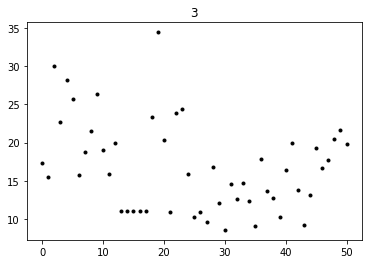

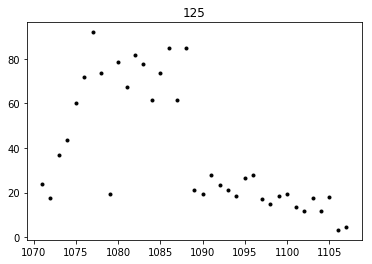

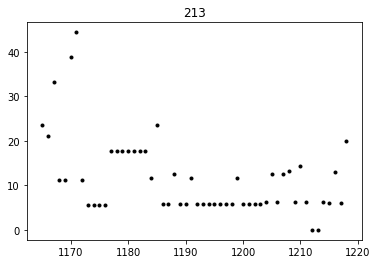

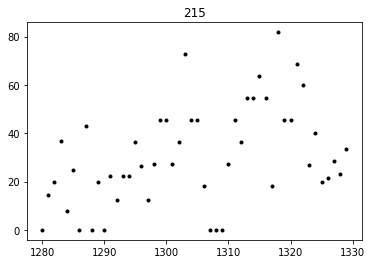

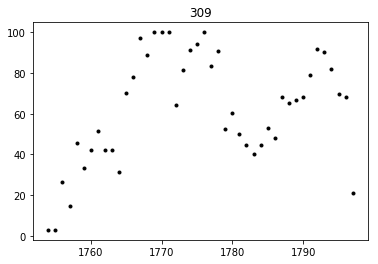

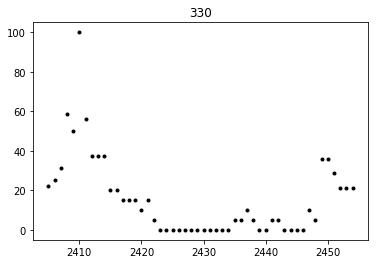

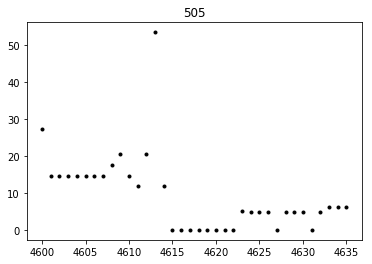

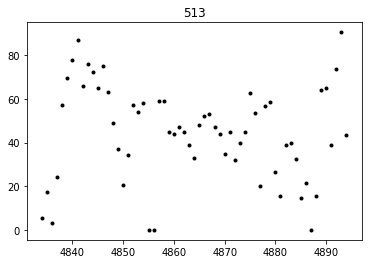

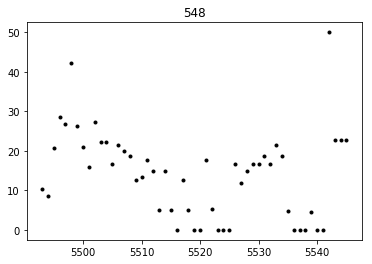

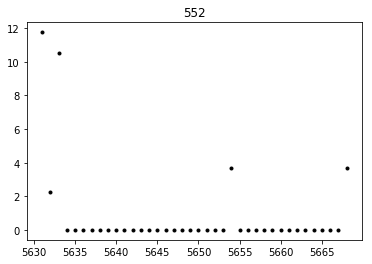

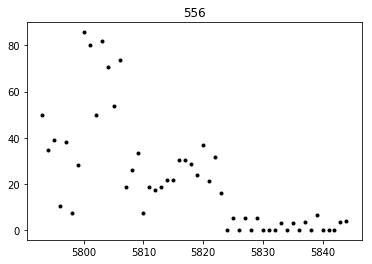

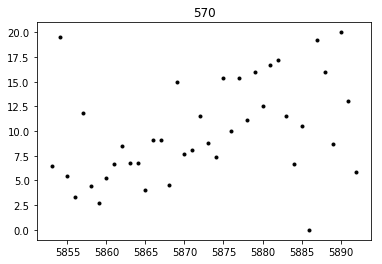

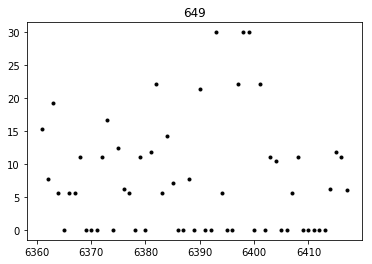

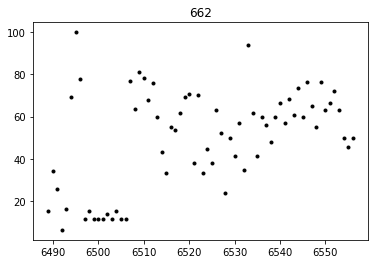

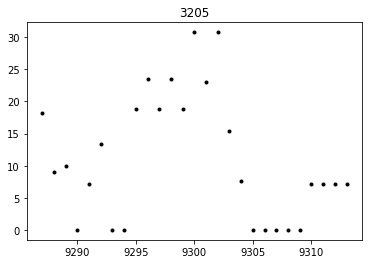

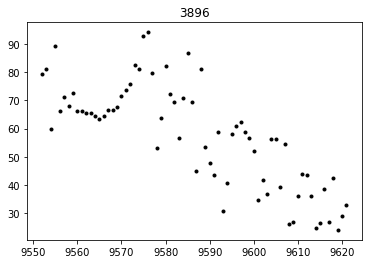

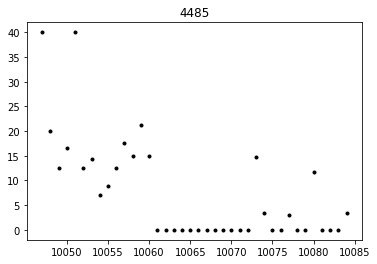

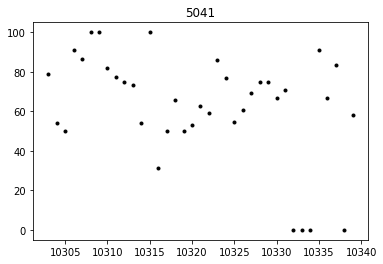

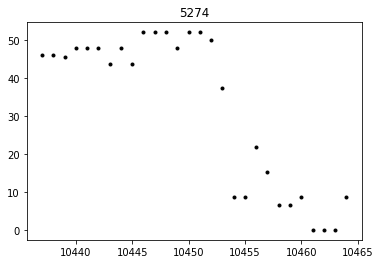

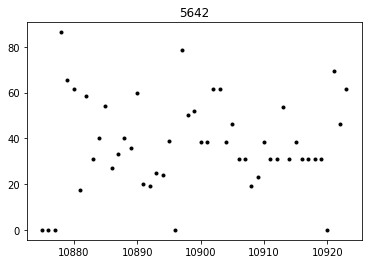

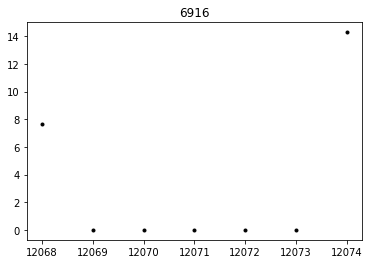

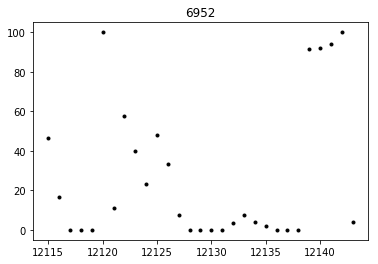

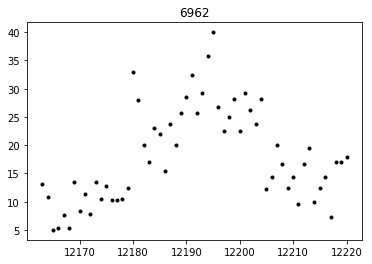

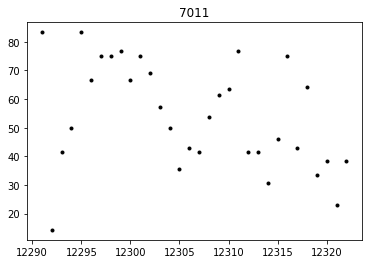

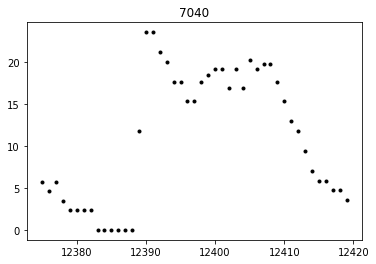

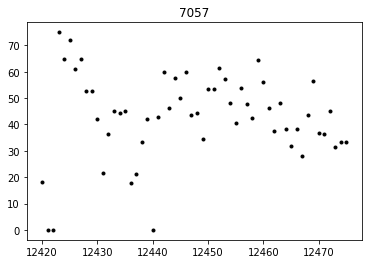

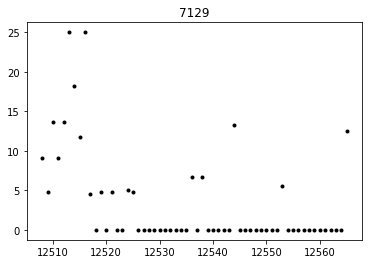

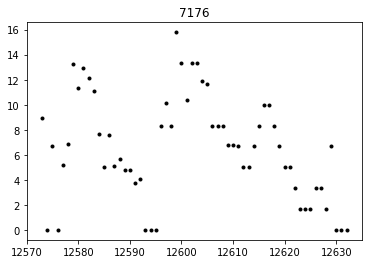

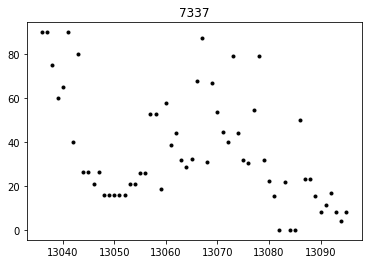

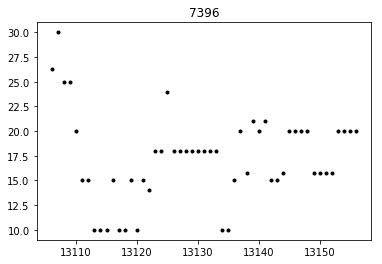

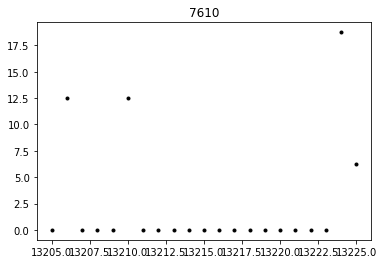

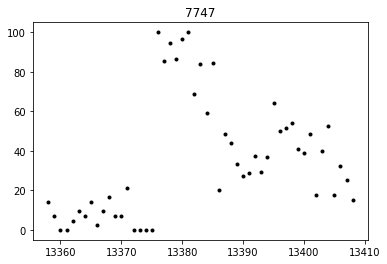

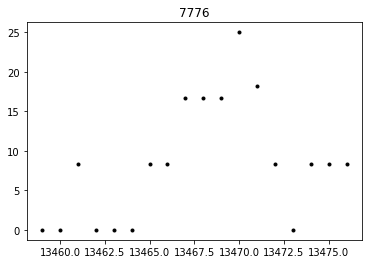

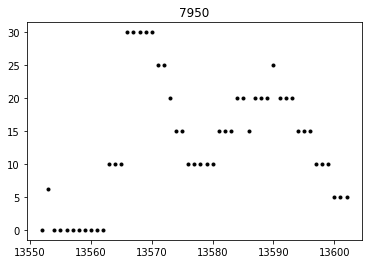

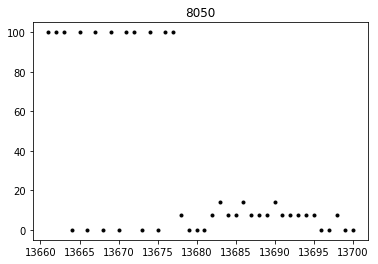

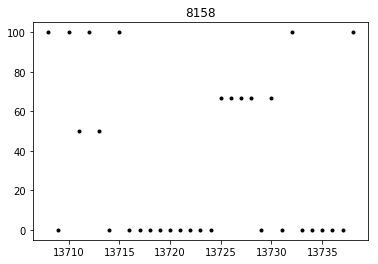

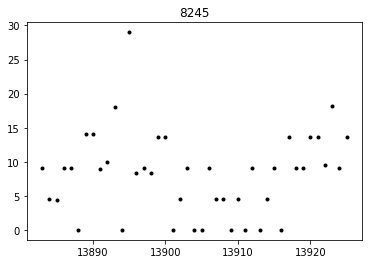

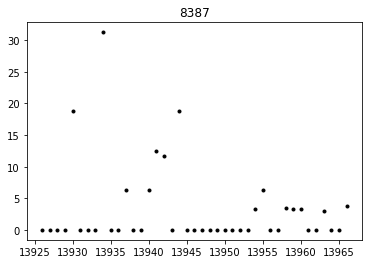

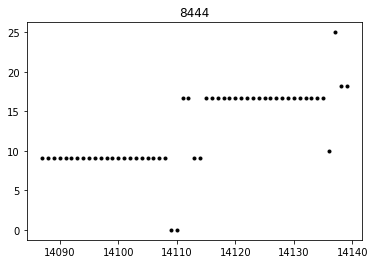

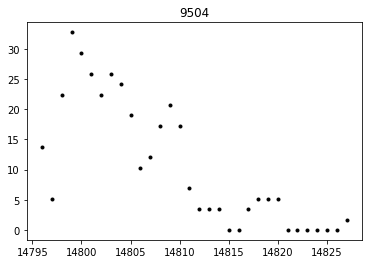

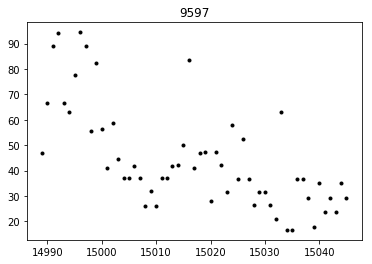

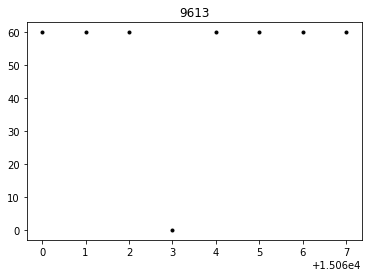

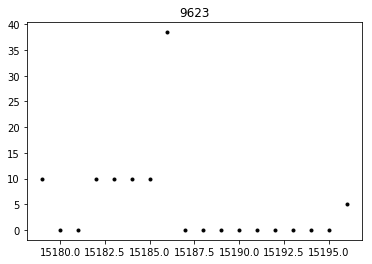

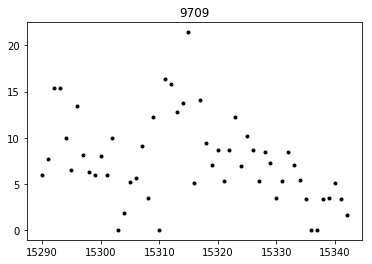

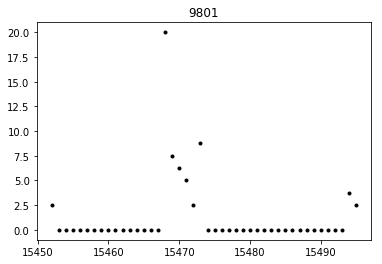

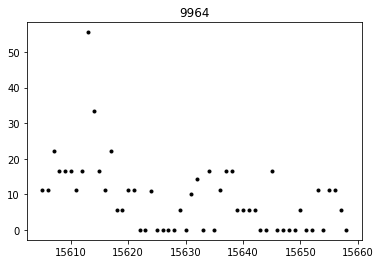

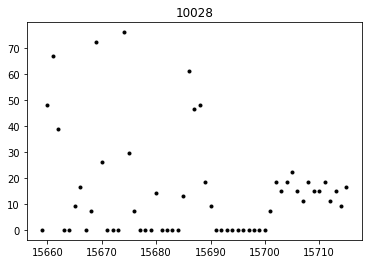

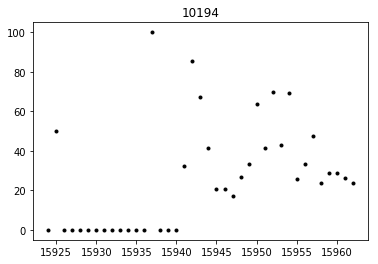

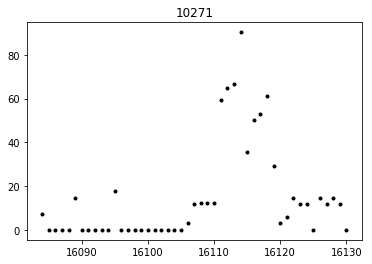

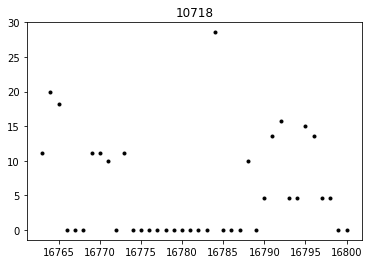

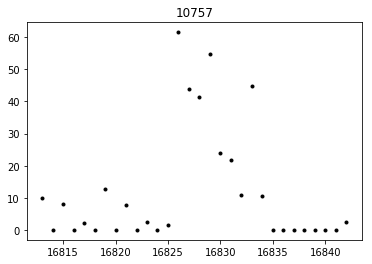

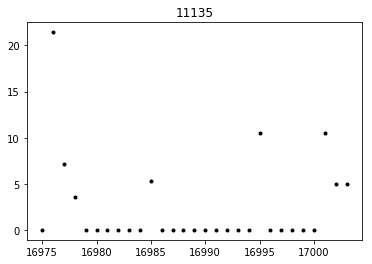

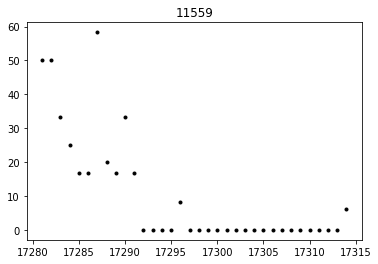

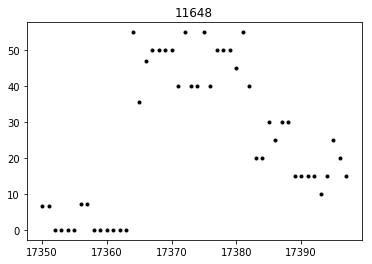

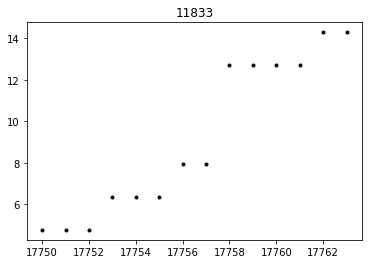

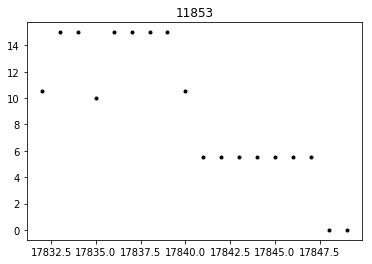

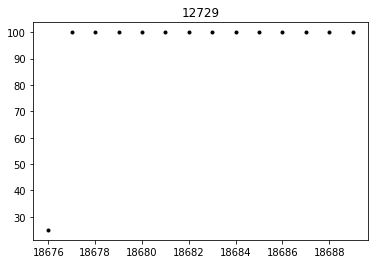

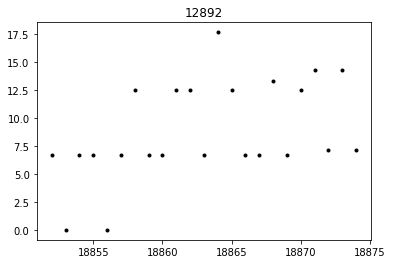

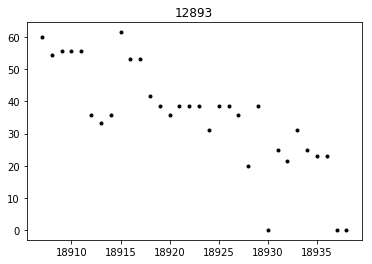

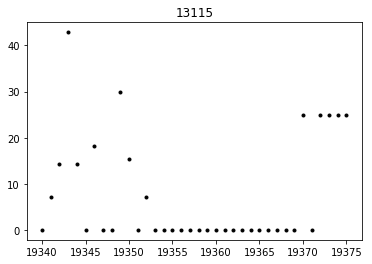

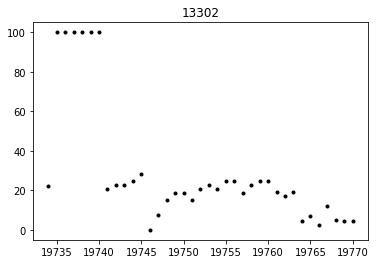

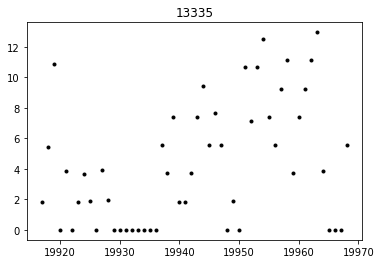

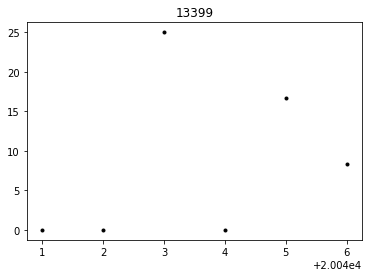

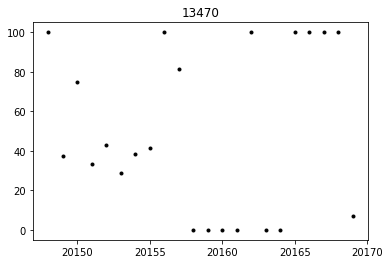

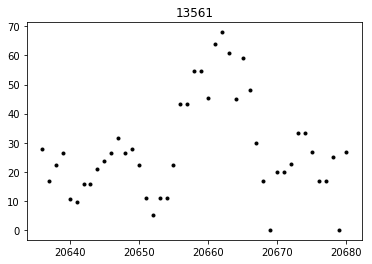

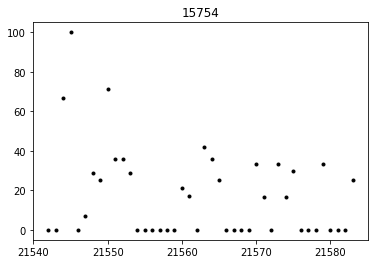

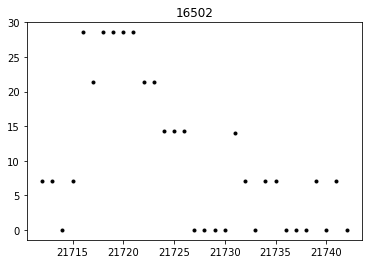

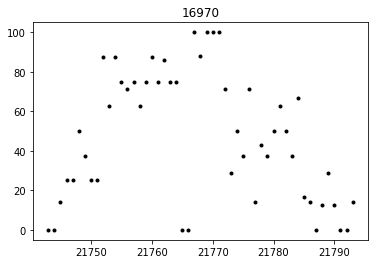

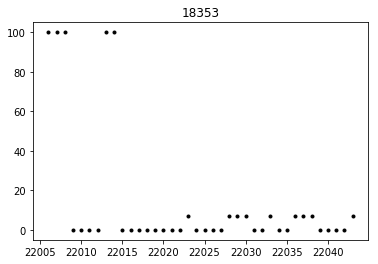

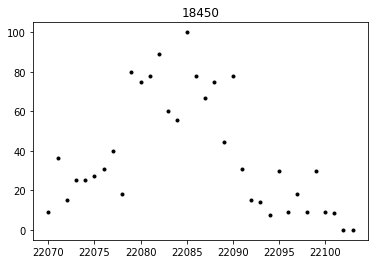

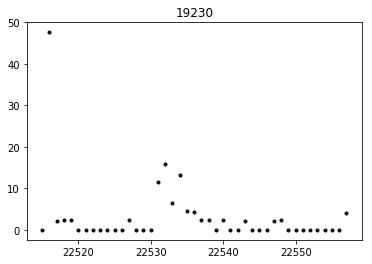

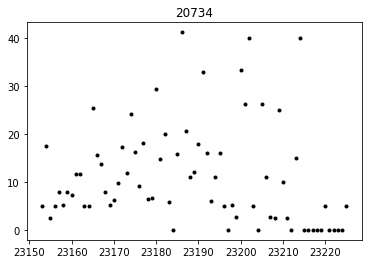

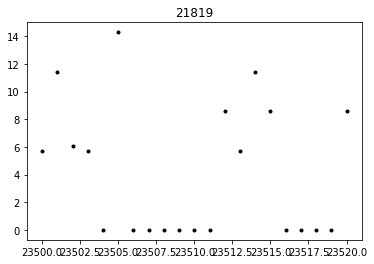

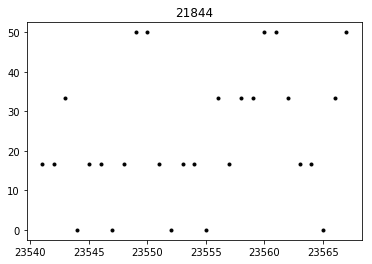

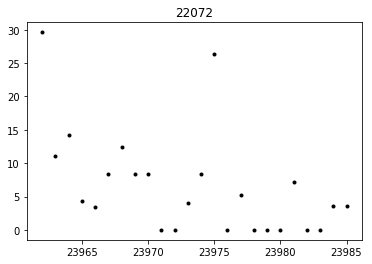

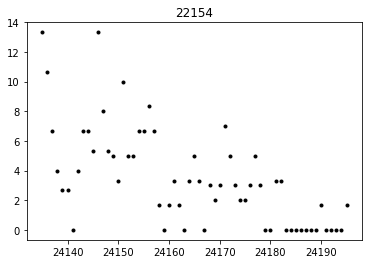

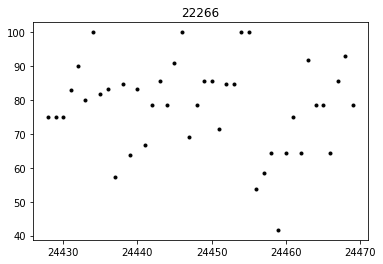

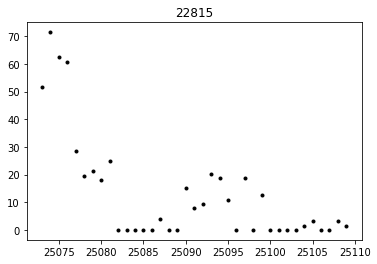

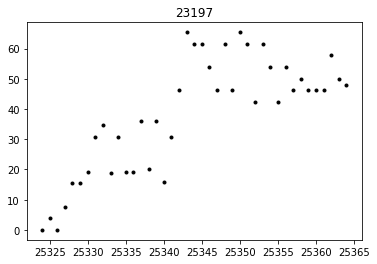

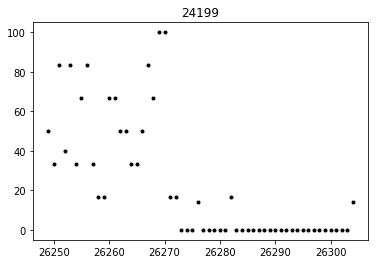

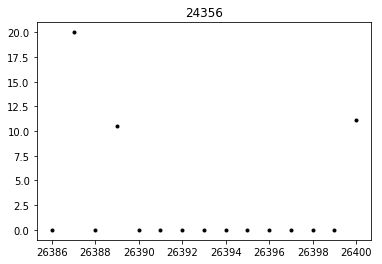

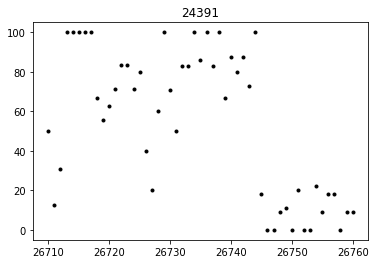

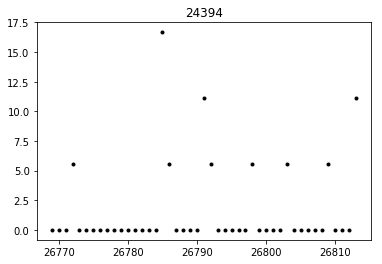

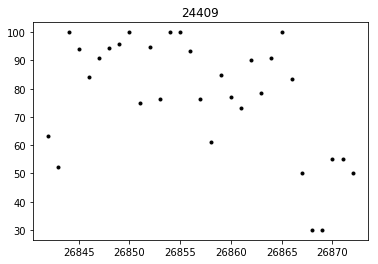

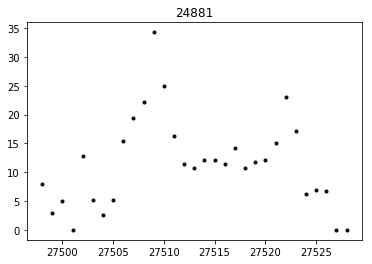

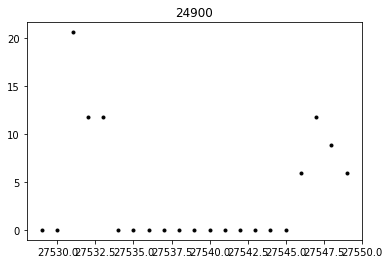

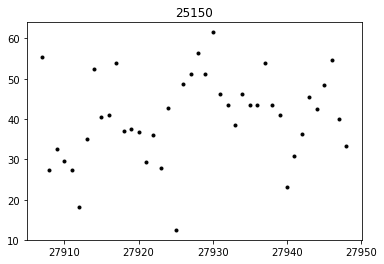

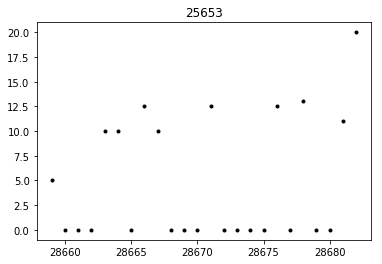

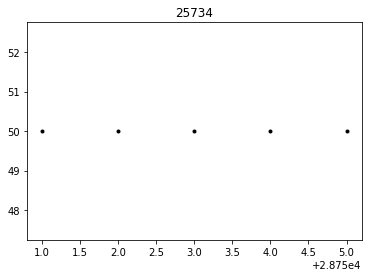

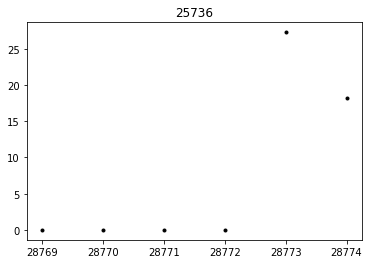

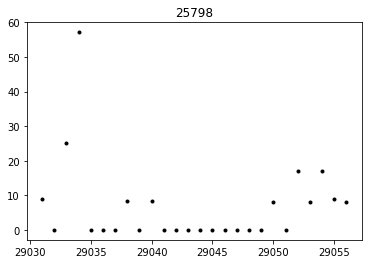

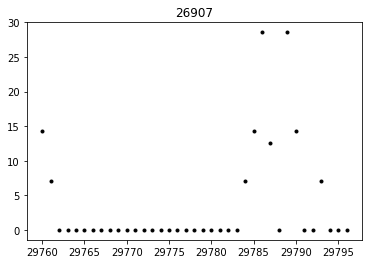

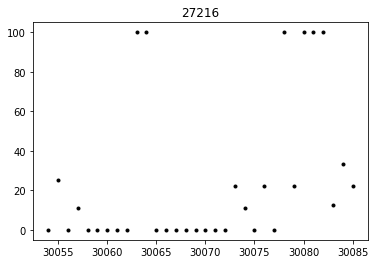

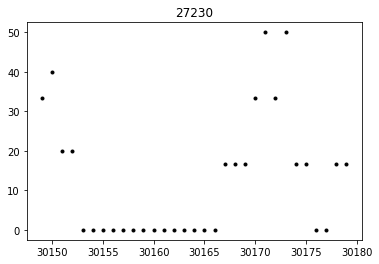

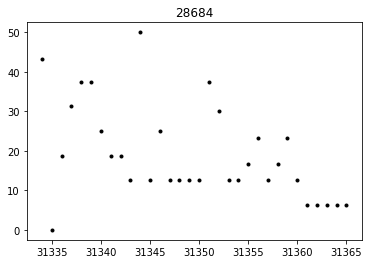

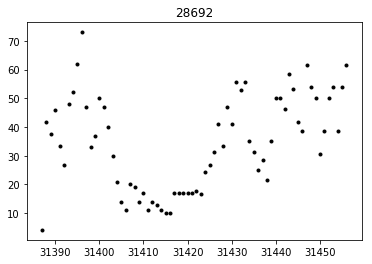

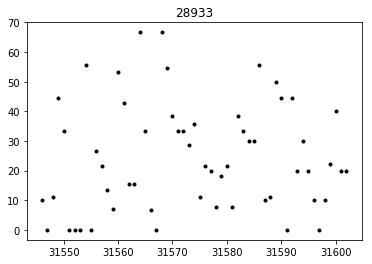

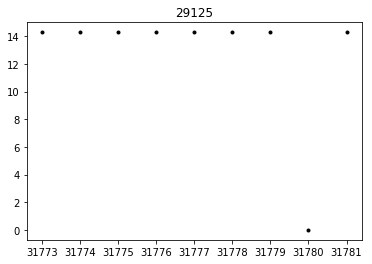

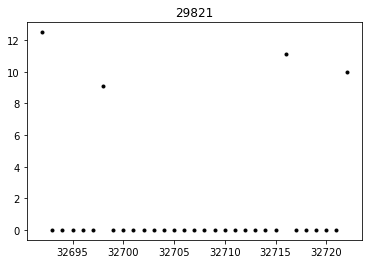

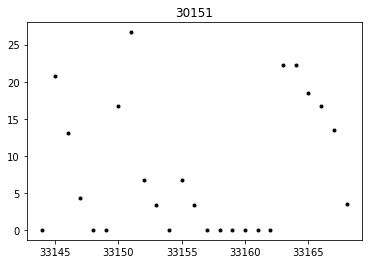

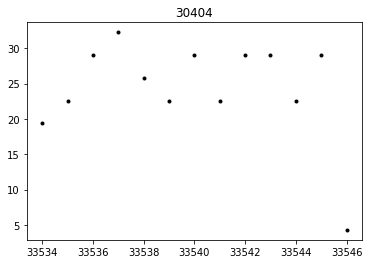

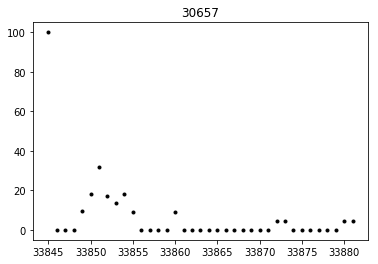

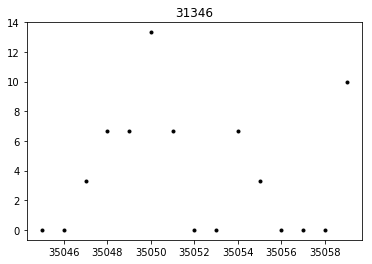

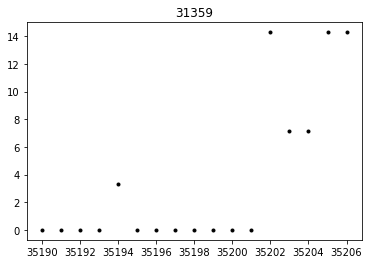

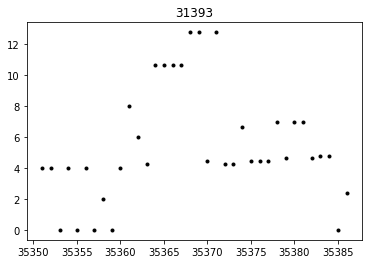

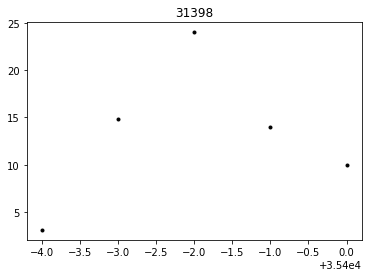

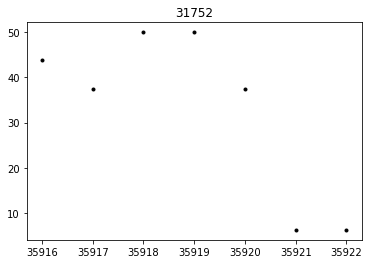

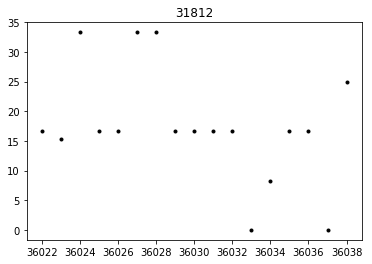

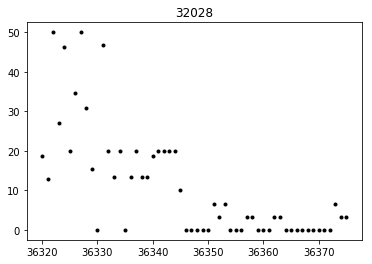

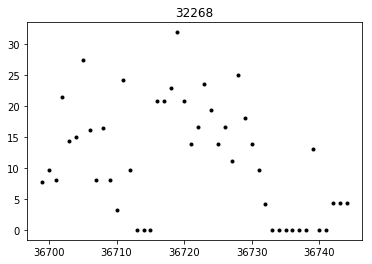

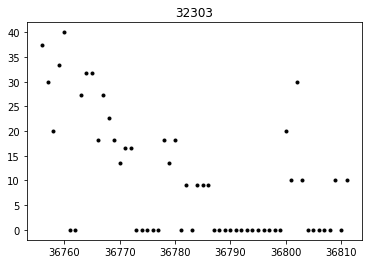

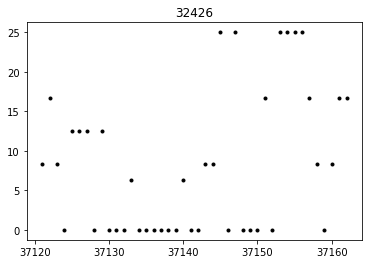

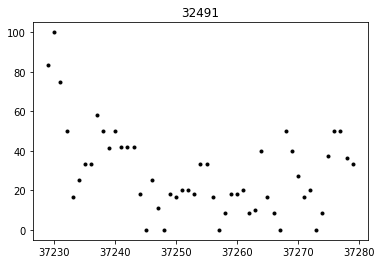

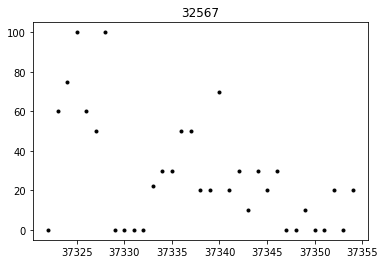

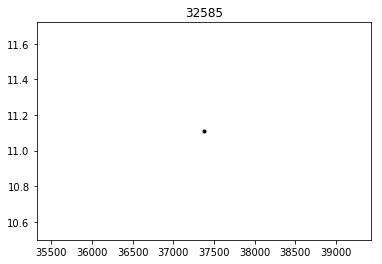

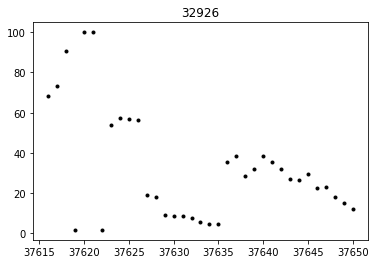

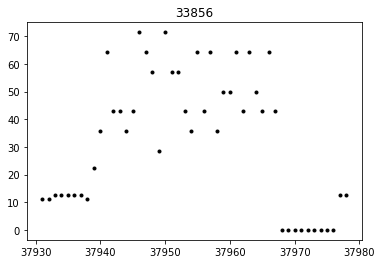

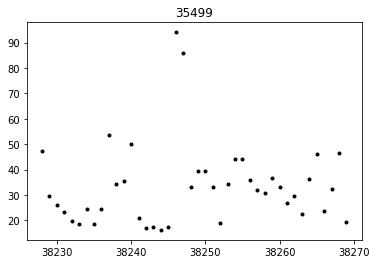

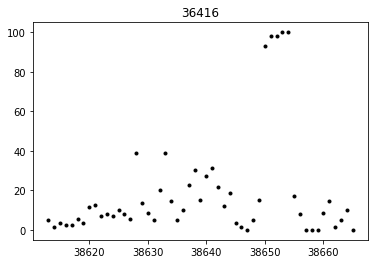

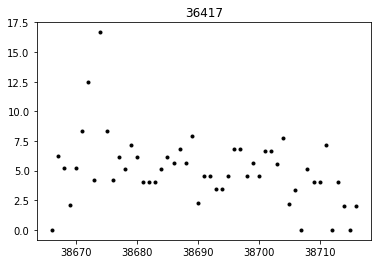

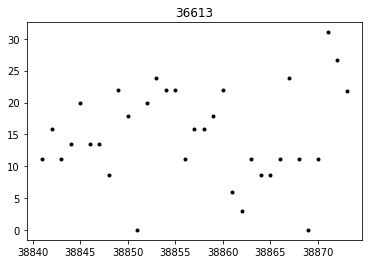

In [61]:
from matplotlib import pyplot as plt
%matplotlib inline
# Plot OviTrap index per school for a certain district

for school in ids:
    df_school = df[df['id']==school]
    df_school['value'].plot(style='k.')
    plt.title(school)
    plt.set_ylim=(0, 100)
    plt.show()

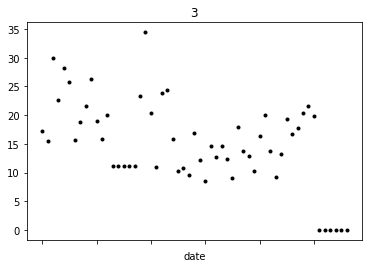

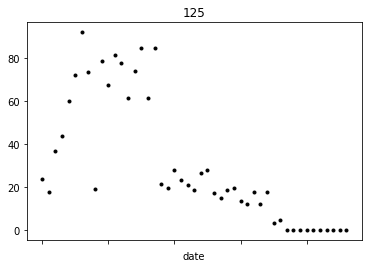

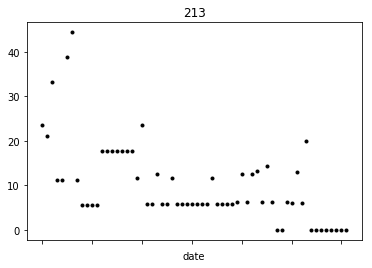

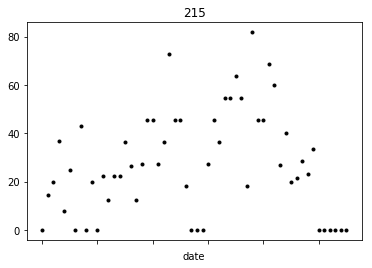

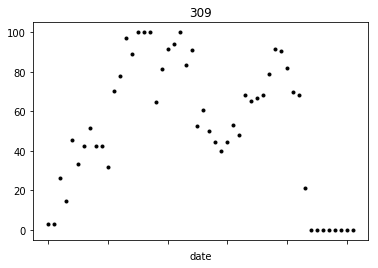

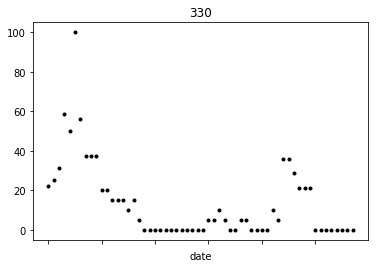

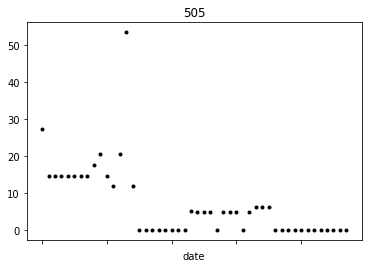

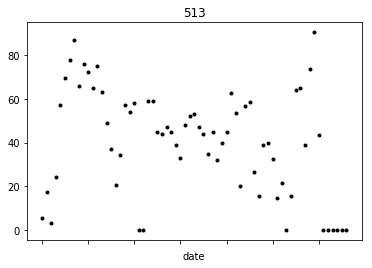

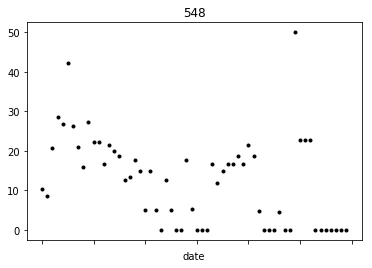

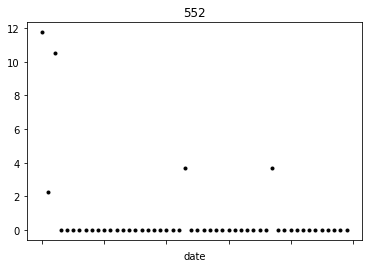

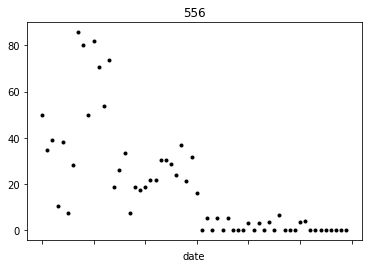

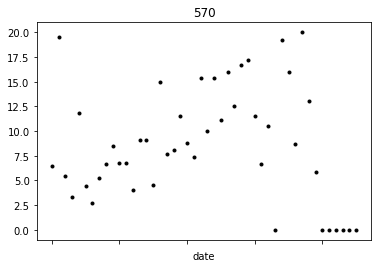

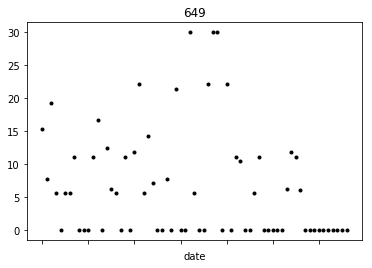

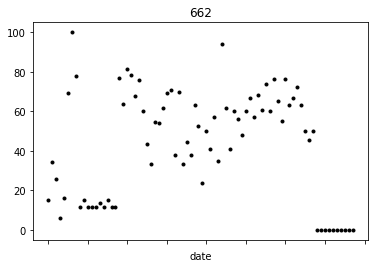

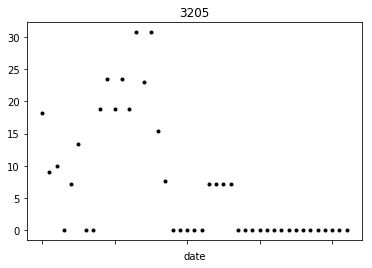

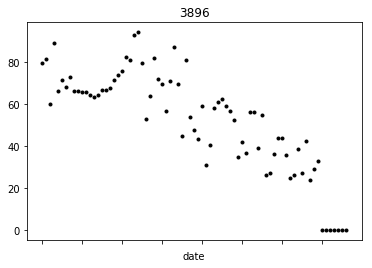

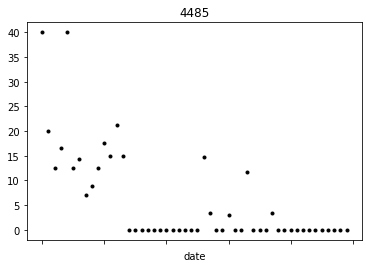

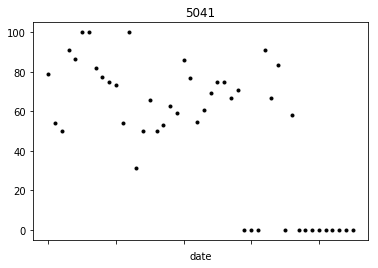

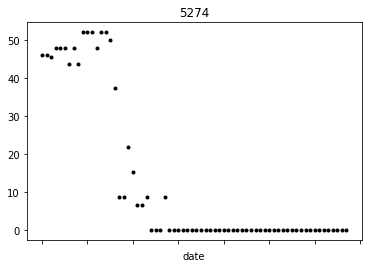

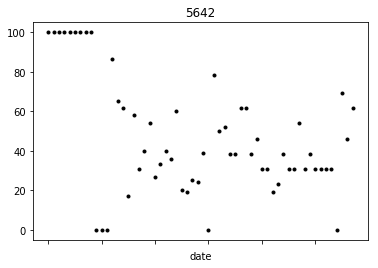

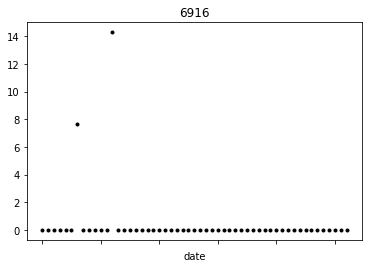

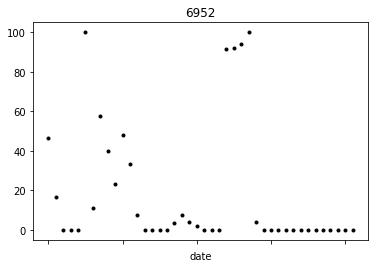

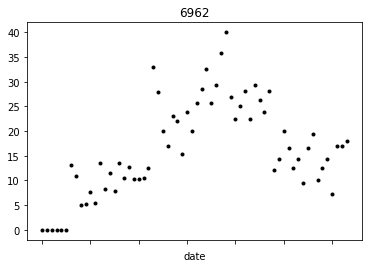

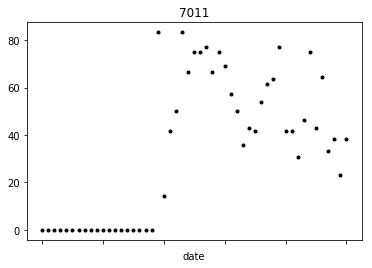

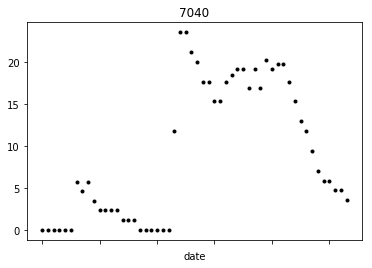

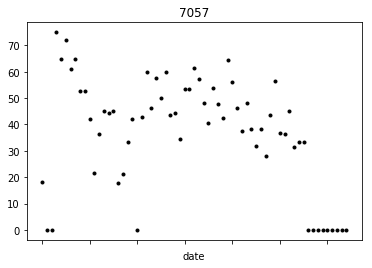

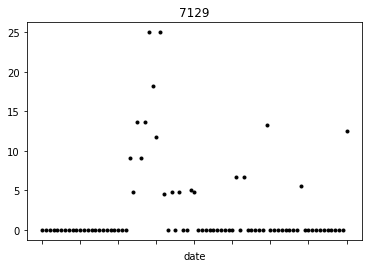

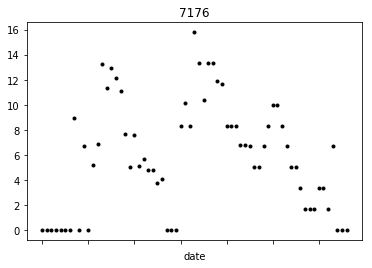

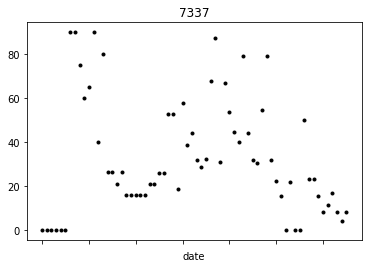

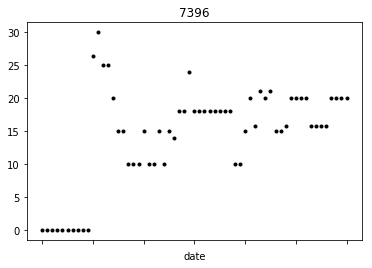

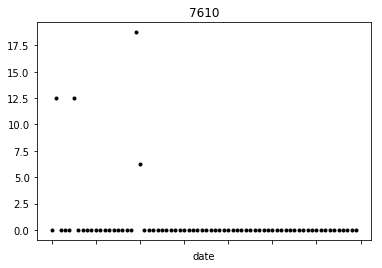

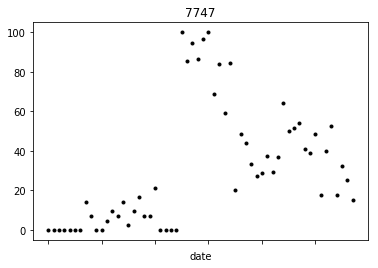

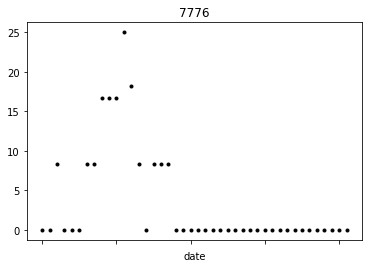

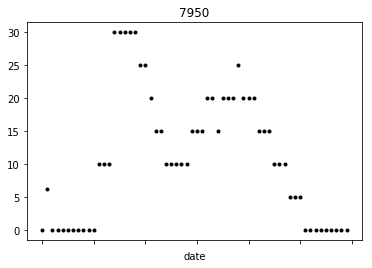

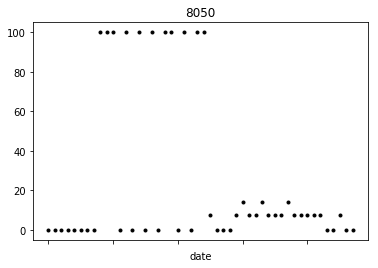

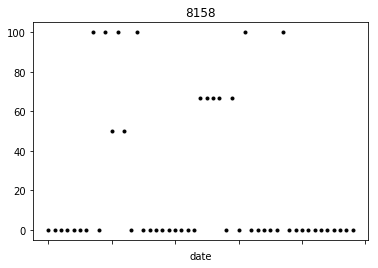

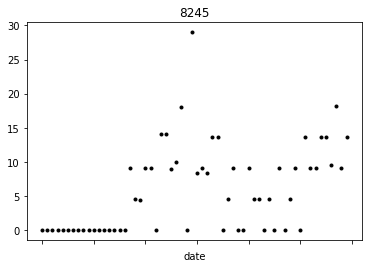

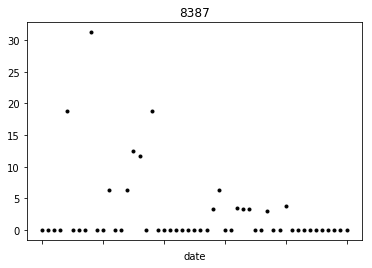

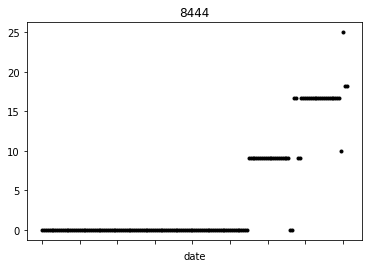

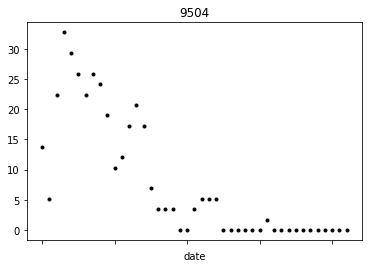

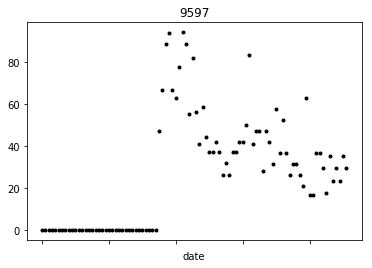

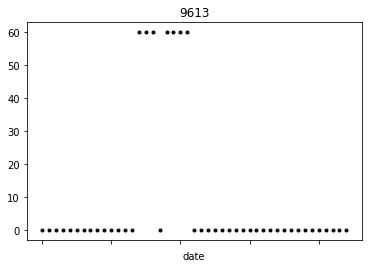

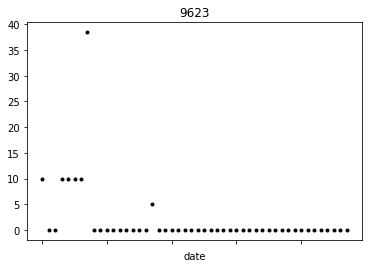

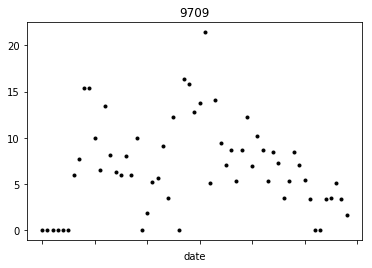

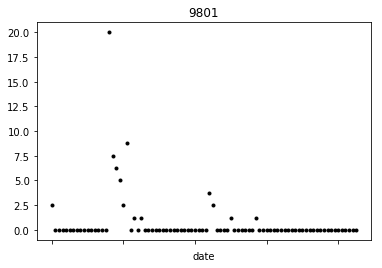

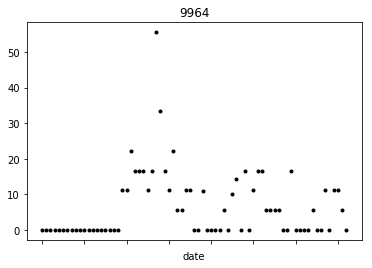

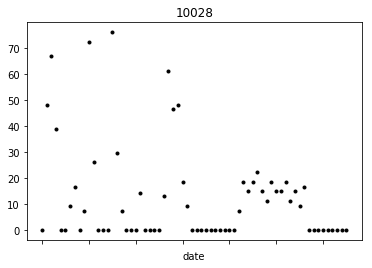

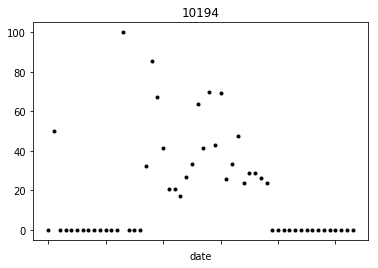

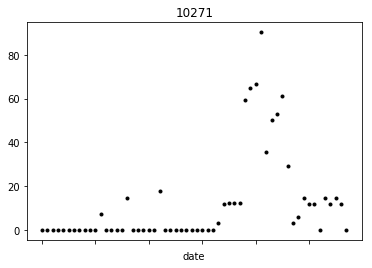

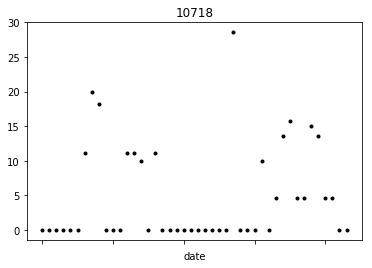

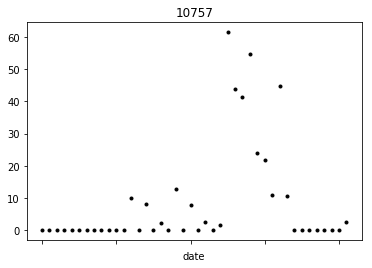

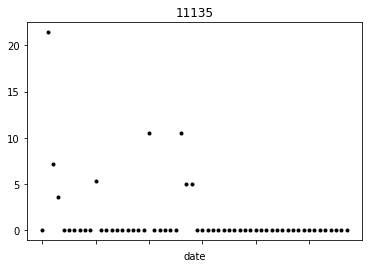

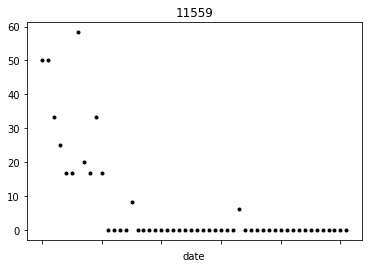

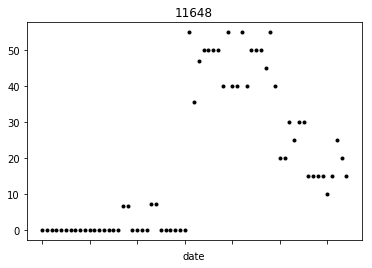

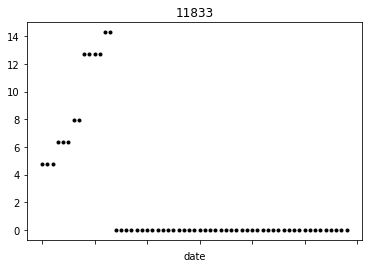

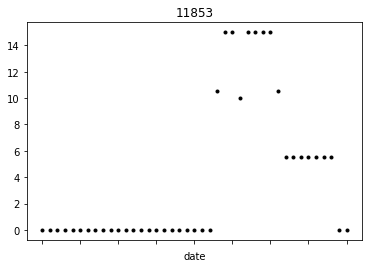

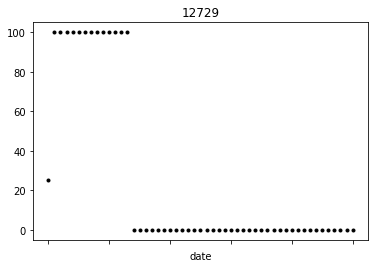

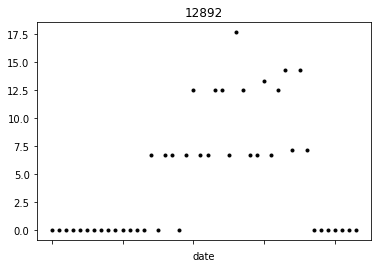

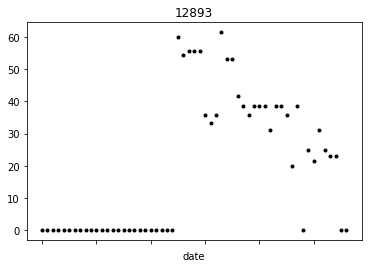

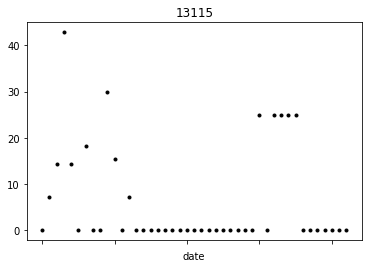

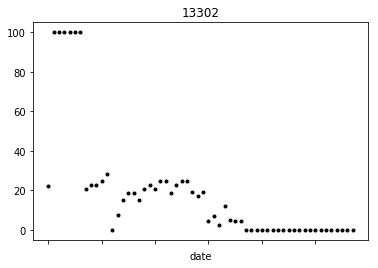

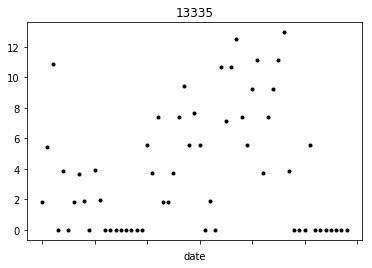

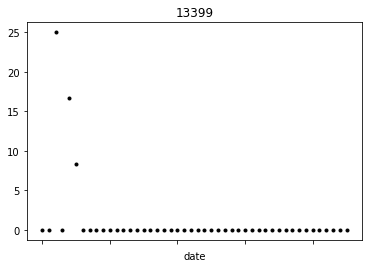

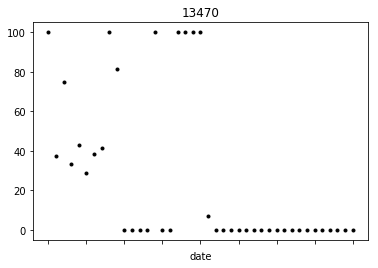

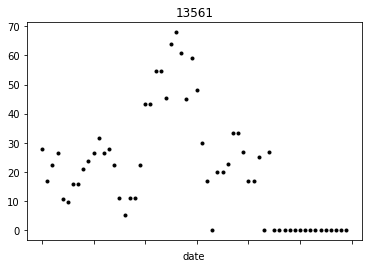

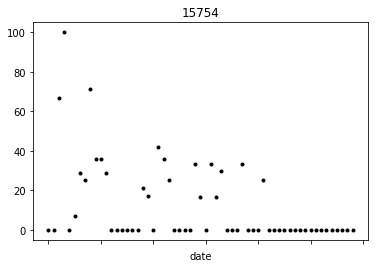

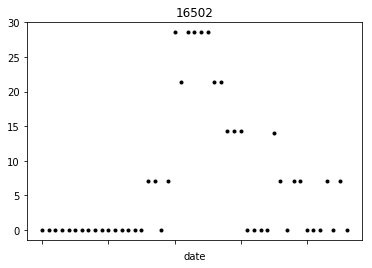

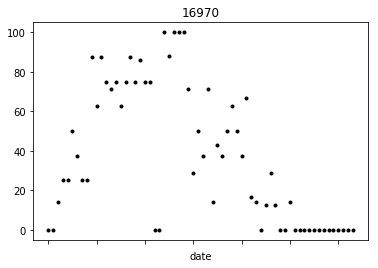

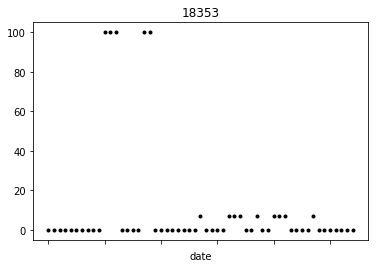

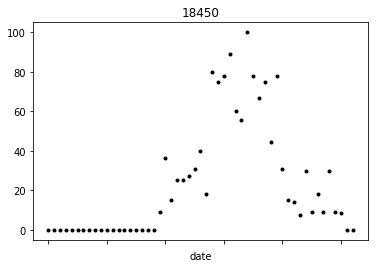

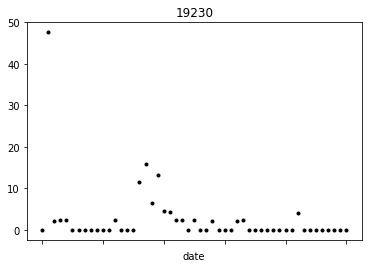

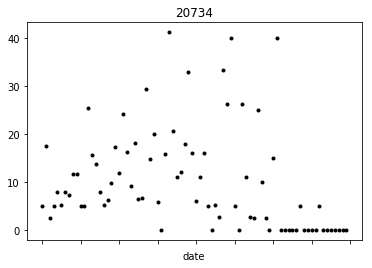

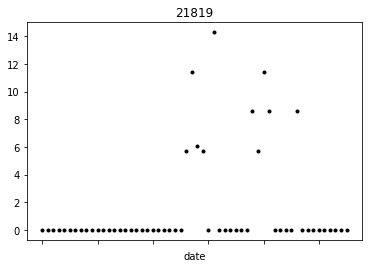

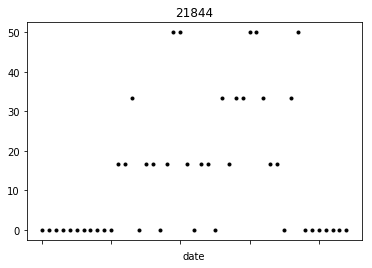

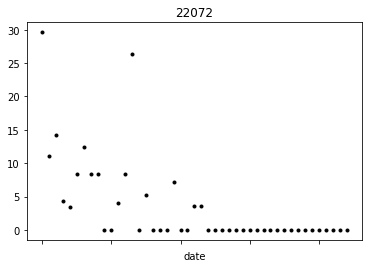

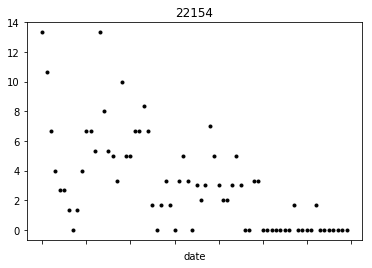

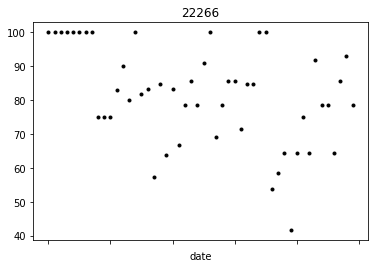

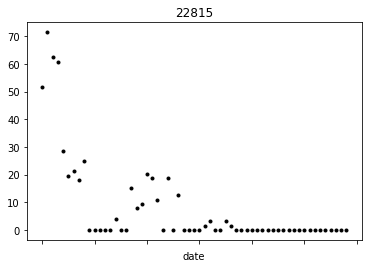

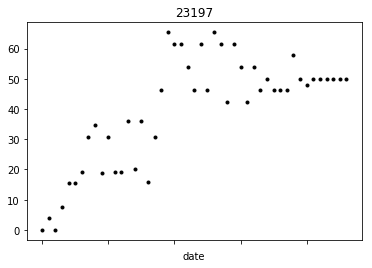

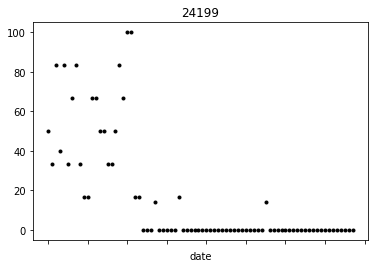

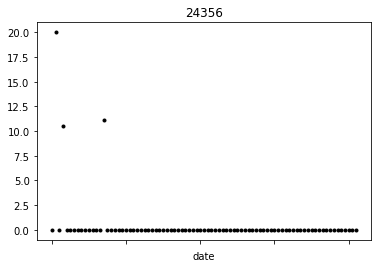

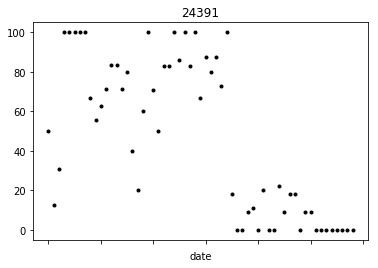

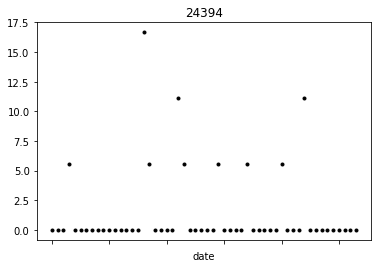

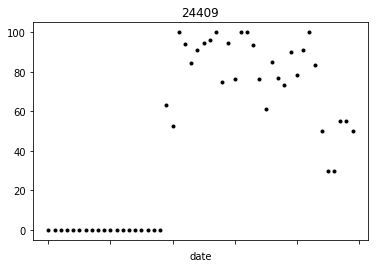

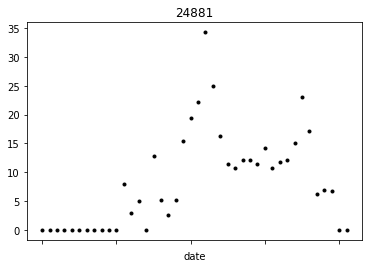

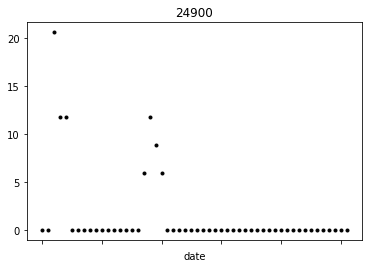

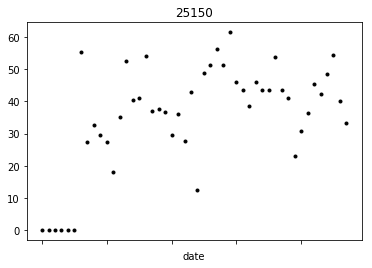

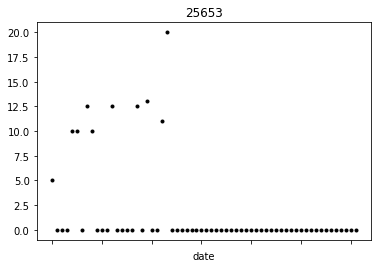

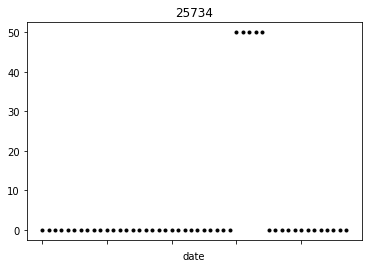

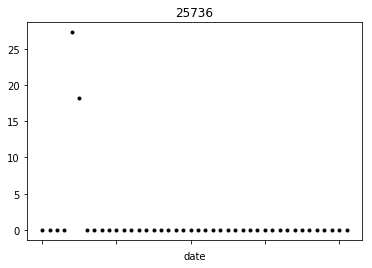

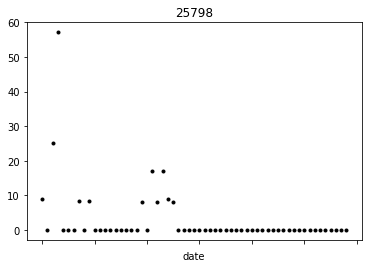

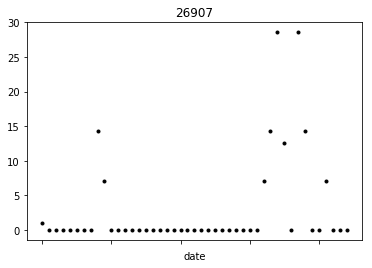

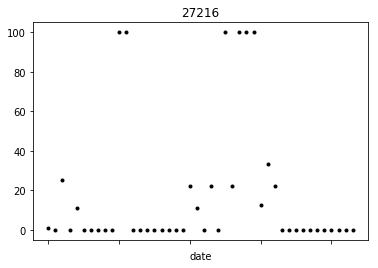

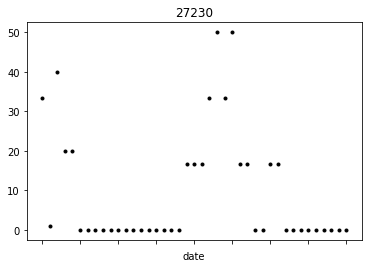

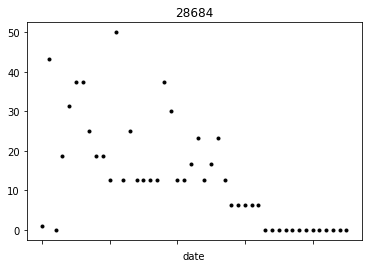

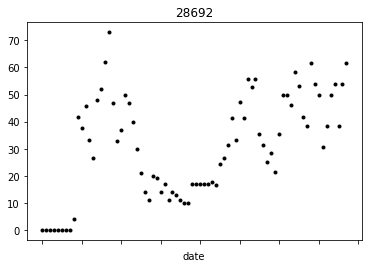

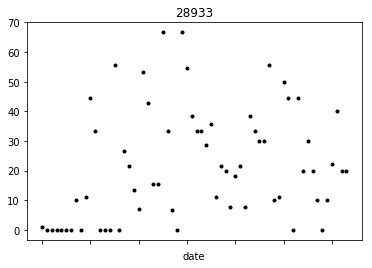

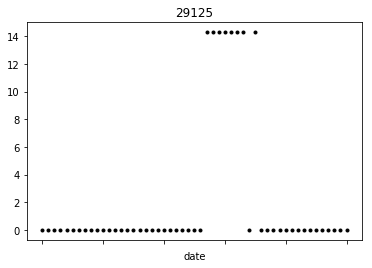

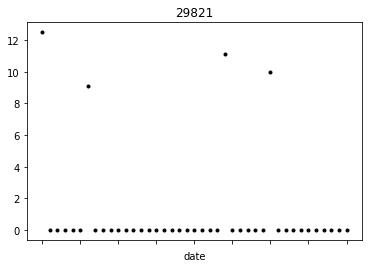

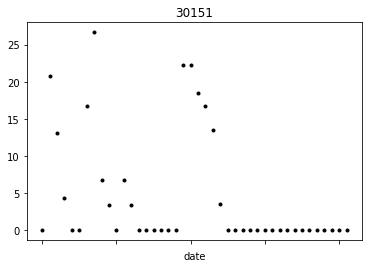

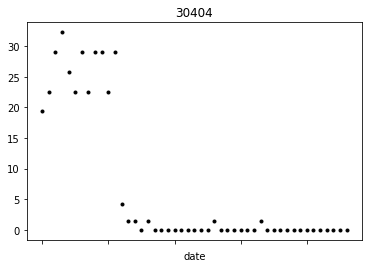

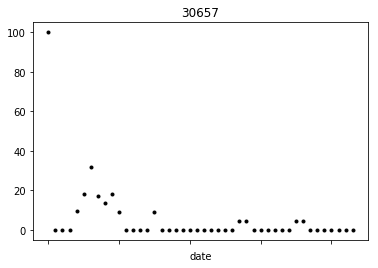

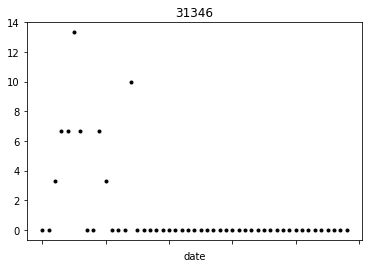

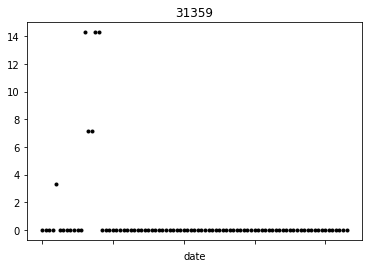

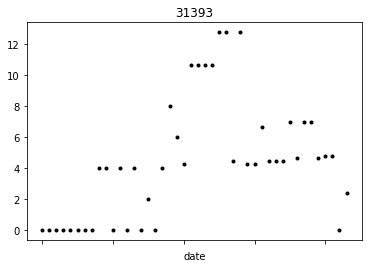

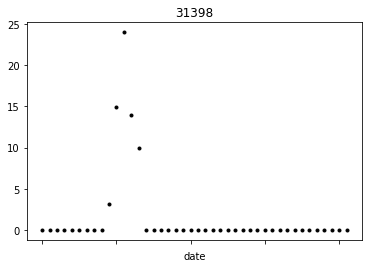

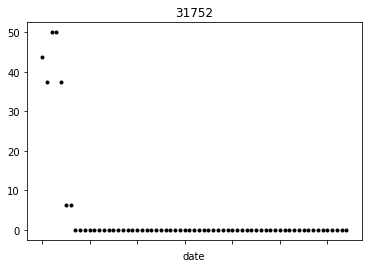

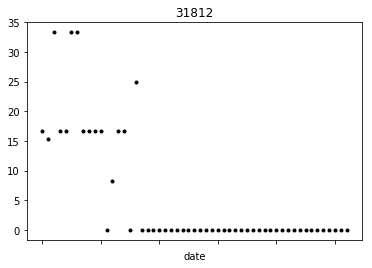

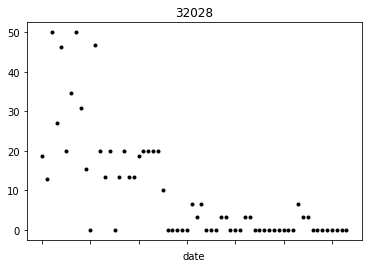

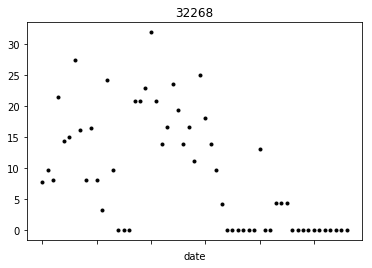

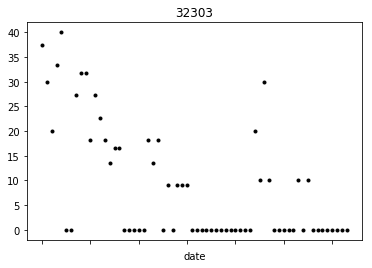

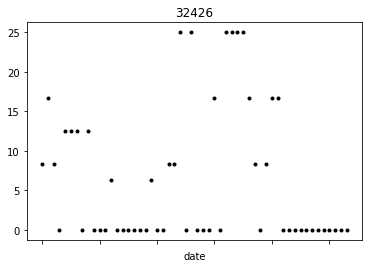

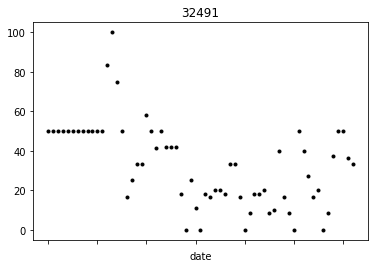

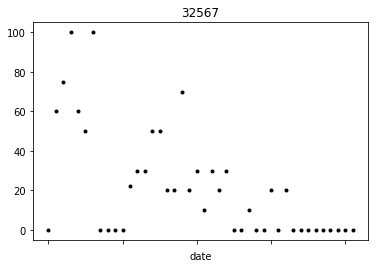

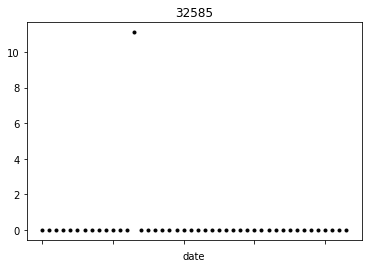

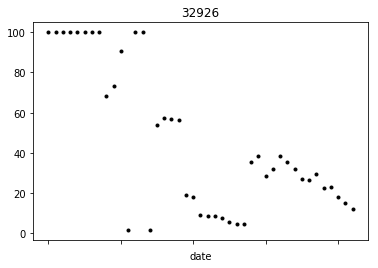

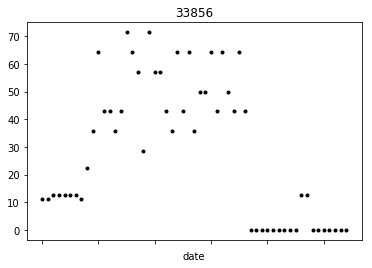

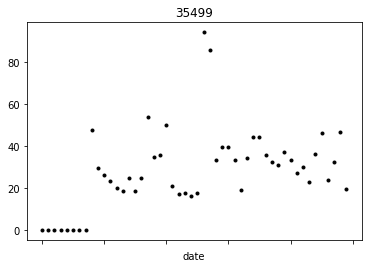

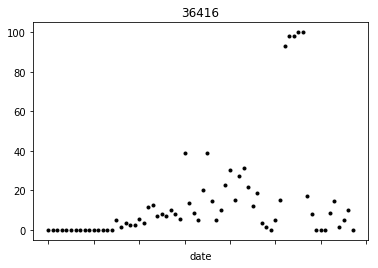

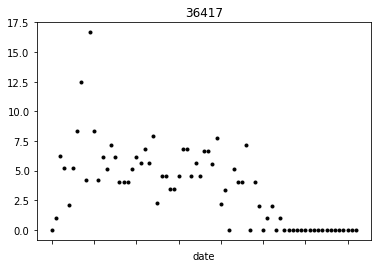

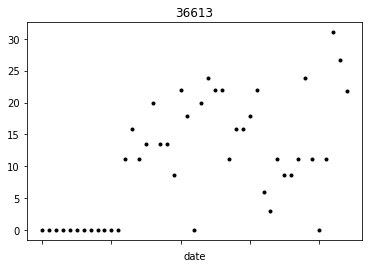

In [63]:
from matplotlib import pyplot as plt
%matplotlib inline
# Plot OviTrap index per school for a certain district

for school in ids:
    df_school = df[df['id']==school]
    df_school['value'].plot(style='k.')
    plt.title(school)
    plt.set_ylim=(0, 100)
    plt.show()

In [60]:
ids = check_df_id.id.unique().tolist()

In [59]:
check_df_id

,date,id,value,adm,Recurring value,first_last
51,2015-11-10,3,0.0,"NCR, Fourth District",6.0,1.0
52,2015-11-17,3,0.0,"NCR, Fourth District",6.0,1.0
53,2015-11-24,3,0.0,"NCR, Fourth District",6.0,1.0
54,2016-01-12,3,0.0,"NCR, Fourth District",6.0,1.0
55,2016-01-19,3,0.0,"NCR, Fourth District",6.0,1.0
56,2016-01-26,3,0.0,"NCR, Fourth District",6.0,1.0
1108,2015-09-02,125,0.0,"NCR, Second District",10.0,1.0
1109,2015-09-09,125,0.0,"NCR, Second District",10.0,1.0
1110,2015-09-16,125,0.0,"NCR, Second District",10.0,1.0
1111,2015-10-13,125,0.0,"NCR, Second District",10.0,1.0


In [56]:
school

51

In [58]:
df[df['id']==51]

,date,id,value,adm
